In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import tensorflow as tf

In [ ]:
ALPHA = 2.
LOSS_WEIGHTS = [
    10,
    1,
    1,
    1,
    10,
]

In [ ]:
# Set data type
DTYPE='float64'
tf.keras.backend.set_floatx(DTYPE)

# Set random seed for reproducible results
tf.random.set_seed(0)

u(x1, x2, t)

x1, x2 => coordenadas espaciais

t => tempo

In [ ]:
# Define initial condition
def fun_u_0(x_0, x_1):
    return tf.zeros((x_0.shape[0], 1), DTYPE)

# Define boundary condition for left, right, down
def fun_u_b(x):
    return tf.zeros((x,1), dtype=DTYPE)

# Define boundary condition for up
def fun_u_b_upper(x):
    return tf.ones((x,1), dtype=DTYPE)

# Define residual of the PDE
def fun_r(t, x, u, u_t, u_xx, u_yy):
    return u_t - ALPHA * (u_xx + u_yy)

In [ ]:
# Set number of data points
N_0 = 3000 #initial condition
N_b = 200 #boundary
N_r = 10000 #colocation points

# Set boundary
tmin = 0.
tmax = 1

xmin = 0.
xmax = 1

In [ ]:
# Lower bounds
lb = tf.constant([tmin, xmin, xmin], dtype=DTYPE)
# Upper bounds
ub = tf.constant([tmax, xmax, xmax], dtype=DTYPE)

In [ ]:
t_0 = tf.ones((N_0, 1), dtype=DTYPE) * lb[0]

x_0 = tf.random.uniform((N_0, 1), lb[1], ub[1], dtype=DTYPE)
y_0 = tf.random.uniform((N_0, 1), lb[2], ub[2], dtype=DTYPE)

X_0 = tf.concat([t_0, x_0, y_0], axis=1)

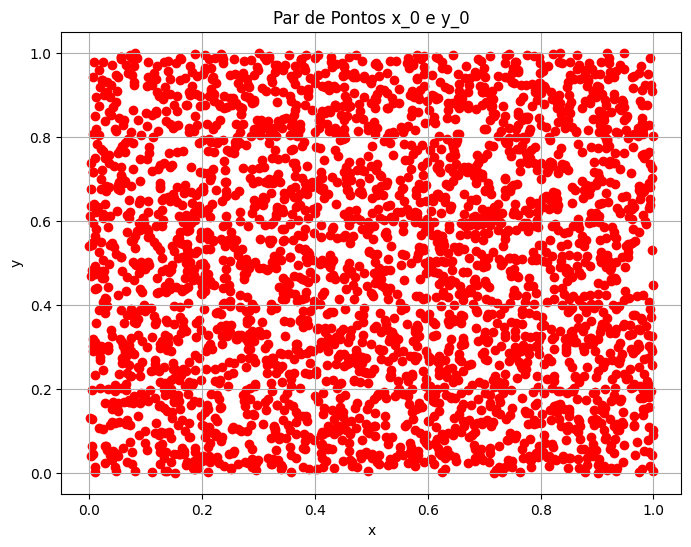

In [ ]:
x_0_np = x_0.numpy().flatten()
y_0_np = y_0.numpy().flatten()

plt.figure(figsize=(8, 6))
plt.scatter(x_0_np, y_0_np, c='r', marker='o')
plt.title('Par de Pontos x_0 e y_0')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.show()

In [ ]:
# Evaluate intitial condition
u_0 = fun_u_0(x_0, y_0)

In [ ]:
# Boundary data
t_b = tf.random.uniform((N_b,1), lb[0], ub[0], dtype=DTYPE)

v1 = tf.zeros((N_b,1), DTYPE)
v2 = tf.ones((N_b,1), DTYPE)
x_0 = tf.random.uniform((N_b, 1), lb[1], ub[1], dtype=DTYPE)
y_0 = tf.random.uniform((N_b, 1), lb[2], ub[2], dtype=DTYPE)

X_b_left = tf.concat([t_b, v1, y_0], axis=1)
X_b_right = tf.concat([t_b, v2, y_0], axis=1)
X_b_down = tf.concat([t_b, x_0, v1], axis=1)
X_b_up = tf.concat([t_b, x_0, v2], axis=1)

# Evaluate boundary condition at (t_b,x_b)
u_b_left = fun_u_b(N_b)
u_b_right = fun_u_b(N_b)
u_b_down = fun_u_b(N_b)
u_b_up = fun_u_b_upper(N_b)

In [ ]:
# Draw uniformly sampled collocation points
t_r = tf.random.uniform((N_r,1), lb[0], ub[0], dtype=DTYPE)
x_r = tf.random.uniform((N_r,1), lb[1], ub[1], dtype=DTYPE)
y_r = tf.random.uniform((N_r,1), lb[2], ub[2], dtype=DTYPE)
X_r = tf.concat([t_r, x_r, y_r], axis=1)

In [ ]:
X_data = [X_0, X_b_left, X_b_right, X_b_down, X_b_up]
u_data = [u_0, u_b_left, u_b_right, u_b_down, u_b_up]

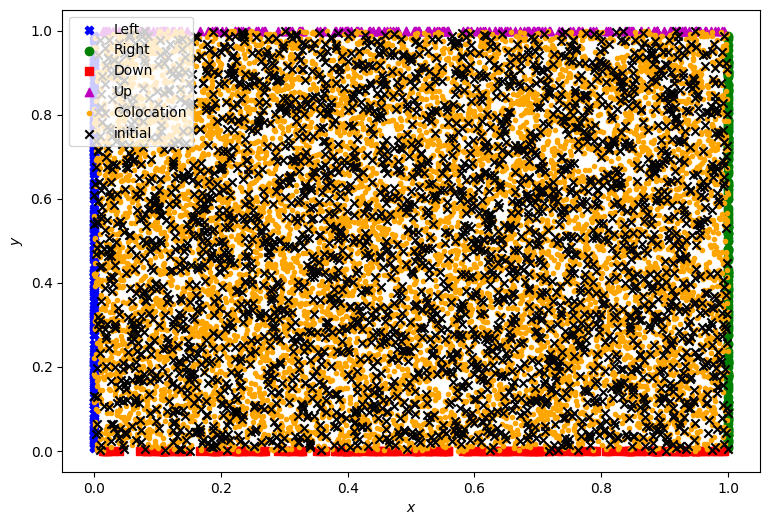

In [ ]:
X_b_left_np = X_b_left.numpy()
X_b_right_np = X_b_right.numpy()
X_b_down_np = X_b_down.numpy()
X_b_up_np = X_b_up.numpy()
X_r_np = X_r.numpy()
X_0_np = X_0.numpy()

# Extraia as colunas necessárias
x_left = X_b_left_np[:, 1]
y_left = X_b_left_np[:, 2]

x_right = X_b_right_np[:, 1]
y_right = X_b_right_np[:, 2]

x_down = X_b_down_np[:, 1]
y_down = X_b_down_np[:, 2]

x_up = X_b_up_np[:, 1]
y_up = X_b_up_np[:, 2]

x_r_new = X_r_np[:, 1]
y_r_new = X_r_np[:, 2]

x_0_new = X_0_np[:, 1]
y_0_new = X_0_np[:, 2]

# Faça o plot
plt.figure(figsize=(9, 6))

plt.scatter(x_left, y_left, c='b', marker='X', label='Left')
plt.scatter(x_right, y_right, c='g', marker='o', label='Right')
plt.scatter(x_down, y_down, c='r', marker='s', label='Down')
plt.scatter(x_up, y_up, c='m', marker='^', label='Up')
plt.scatter(x_r_new, y_r_new, c='orange', marker='.', label='Colocation')
plt.scatter(x_0_new, y_0_new, c='black', marker='x', label='initial')

plt.xlabel('$x$')
plt.ylabel('$y$')
plt.legend()
plt.show()

In [ ]:
def init_model(num_hidden_layers=5, num_neurons_per_layer=60):
    # Initialize a feedforward neural network
    model = tf.keras.Sequential()

    # Input is two-dimensional (time + one spatial dimension)
    model.add(tf.keras.Input(3))

    # Introduce a scaling layer to map input to [lb, ub]
    scaling_layer = tf.keras.layers.Lambda(
                lambda x: tf.abs((x - lb)/(ub - lb)))
    model.add(scaling_layer)

    # Append hidden layers
    for _ in range(num_hidden_layers):
        model.add(tf.keras.layers.Dense(num_neurons_per_layer,
            activation=tf.keras.activations.get('tanh'),
            kernel_initializer='glorot_normal'))

    # Output is one-dimensional
    model.add(tf.keras.layers.Dense(1))

    return model

In [ ]:
def get_r(model, X_r):

    # A tf.GradientTape is used to compute derivatives in TensorFlow
    with tf.GradientTape(persistent=True) as tape:
        # Split t and x to compute partial derivatives
        t, x, y = X_r[:, 0:1], X_r[:,1:2], X_r[:, 2:]

        # Variables t and x are watched during tape
        # to compute derivatives u_t and u_x
        tape.watch(t)
        tape.watch(x)
        tape.watch(y)

        # Determine residual
        u = model(tf.stack([t[:,0], x[:,0], y[:, 0]], axis=1))

        # Compute gradient u_x within the GradientTape
        # since we need second derivatives
        u_x = tape.gradient(u, x)
        u_y = tape.gradient(u, y)

    u_t = tape.gradient(u, t)
    u_xx = tape.gradient(u_x, x)
    u_yy = tape.gradient(u_y, y)

    del tape

    #fun_r(t, x, u, u_t, u_xx, u_yy)
    return fun_r(t, x, u, u_t, u_xx, u_yy)

In [ ]:
def compute_loss(model, X_r, X_data, u_data):

    # Compute phi^r
    r = get_r(model, X_r)
    phi_r = tf.reduce_mean(tf.square(r))

    # Initialize loss
    loss = phi_r

    # Add phi^0 and phi^b to the loss
    for i in range(len(X_data)):
        u_pred = model(X_data[i])
        loss += LOSS_WEIGHTS[i] * tf.reduce_mean(tf.square(u_data[i] - u_pred))

    return loss

In [ ]:
def get_grad(model, X_r, X_data, u_data):

    with tf.GradientTape(persistent=True) as tape:
        # This tape is for derivatives with
        # respect to trainable variables
        tape.watch(model.trainable_variables)
        loss = compute_loss(model, X_r, X_data, u_data)

    g = tape.gradient(loss, model.trainable_variables)
    del tape

    return loss, g

In [ ]:
# Initialize model aka u_\theta
model = init_model()

lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000,3000],[1e-2,1e-3,5e-4])

# Choose the optimizer
optim = tf.keras.optimizers.Adam(learning_rate=0.0001)

In [ ]:
from time import time

# Define one training step as a TensorFlow function to increase speed of training
@tf.function
def train_step():
    # Compute current loss and gradient w.r.t. parameters
    loss, grad_theta = get_grad(model, X_r, X_data, u_data)

    # Perform gradient descent step
    optim.apply_gradients(zip(grad_theta, model.trainable_variables))

    return loss

# Number of training epochs
N = 5000
hist = []

# Start timer
t0 = time()

for i in range(N+1):

    loss = train_step()

    # Append current loss to hist
    hist.append(loss.numpy())

    # Output current loss after 50 iterates
    if i%50 == 0:
        print('It {:05d}: loss = {:10.8e}'.format(i,loss))

# Print computation time
print('\nComputation time: {} seconds'.format(time()-t0))

It 00000: loss = 2.01844705e+01
It 00050: loss = 3.46496045e+00
It 00100: loss = 2.92920942e+00
It 00150: loss = 2.66954635e+00
It 00200: loss = 2.47624386e+00
It 00250: loss = 2.31154561e+00
It 00300: loss = 2.17488938e+00
It 00350: loss = 2.06756645e+00
It 00400: loss = 1.98731451e+00
It 00450: loss = 1.92885095e+00
It 00500: loss = 1.88655371e+00
It 00550: loss = 1.85566274e+00
It 00600: loss = 1.83215188e+00
It 00650: loss = 1.81288139e+00
It 00700: loss = 1.79580132e+00
It 00750: loss = 1.77973889e+00
It 00800: loss = 1.76400525e+00
It 00850: loss = 1.74810730e+00
It 00900: loss = 1.73159985e+00
It 00950: loss = 1.71401546e+00
It 01000: loss = 1.69482775e+00
It 01050: loss = 1.67343267e+00
It 01100: loss = 1.64914986e+00
It 01150: loss = 1.62125791e+00
It 01200: loss = 1.58908220e+00
It 01250: loss = 1.55213877e+00
It 01300: loss = 1.51028420e+00
It 01350: loss = 1.46374562e+00
It 01400: loss = 1.41291860e+00
It 01450: loss = 1.35820207e+00
It 01500: loss = 1.30055559e+00
It 01550

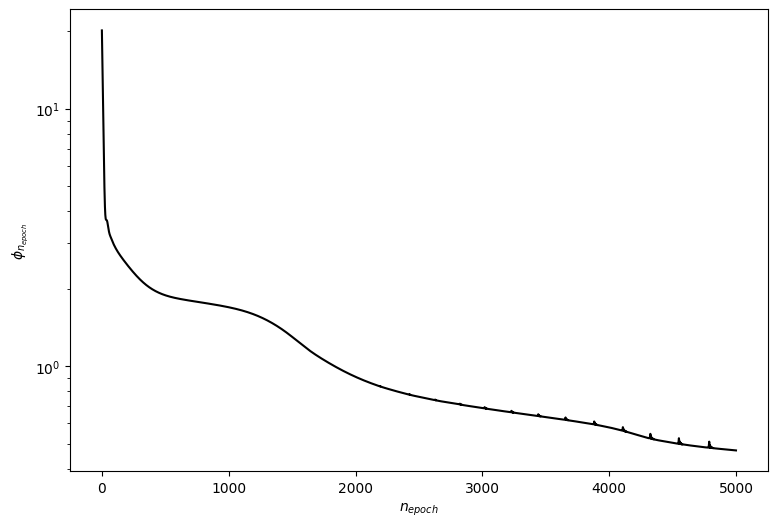

In [ ]:
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
ax.semilogy(range(len(hist)), hist,'k-')
ax.set_xlabel('$n_{epoch}$')
ax.set_ylabel('$\\phi_{n_{epoch}}$');

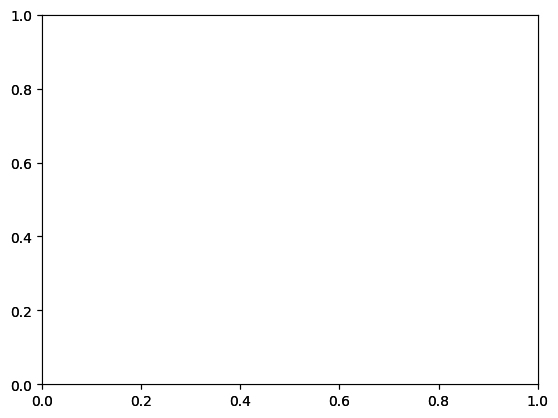

In [ ]:
# Predict the solution at different time points and create an animation
fig, ax = plt.subplots()
ax = fig.add_subplot(111)

# Set up the grid
nelx = 100  # Number of elements in x direction
nely = 100  # Number of elements in y direction
timesteps = 101  # Number of time steps
x = np.linspace(0, 1, nelx + 1)  # x coordinates
y = np.linspace(0, 1, nely + 1)  # y coordinates
t = np.linspace(0, 1, timesteps)  # Time points

# Prepare the data for the prediction
test_x, test_y, test_t = np.meshgrid(x, y, t)
test_domain = np.vstack((np.ravel(test_x), np.ravel(test_y), np.ravel(test_t))).T

In [ ]:
# Predict Solution and Residual
predicted_solution = model.predict(test_domain)
predicted_solution = predicted_solution.reshape(
    test_x.shape
)  # Scale and reshape solution

32197/32197 [==============================] - 56s 2ms/step


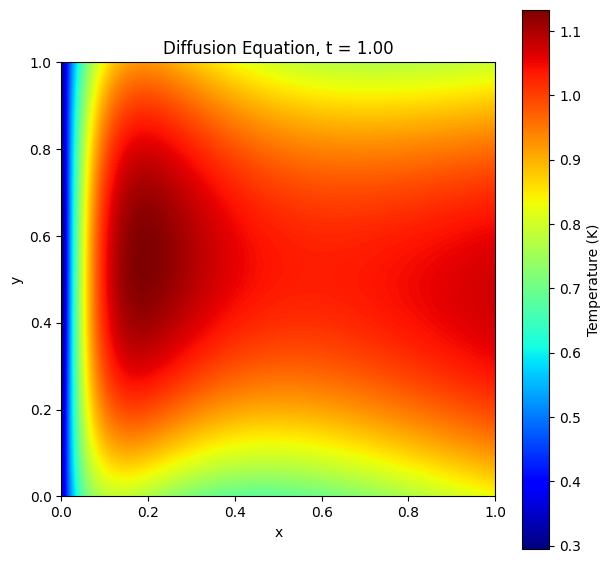

In [ ]:
# Animation function
def animate_solution(data, filename, title, label, t_data):
    fig, ax = plt.subplots(figsize=(7, 7))

    # Create initial image and colorbar
    im = ax.imshow(
        data[:, :, 0],
        origin="lower",
        cmap="jet",
        interpolation="bilinear",
        extent=[0, 1, 0, 1],
    )
    cb = plt.colorbar(im, ax=ax, label=label)
    ax.set_xlabel("x")
    ax.set_ylabel("y")

    # Update function for the frames
    def updatefig(k):
        # Update image data
        im.set_array(data[:, :, k])
        im.set_clim(
            vmin=data[:, :, k].min(), vmax=data[:, :, k].max()
        )  # Update the color limits

        # Update colorbar
        cb.update_normal(im)

        # Update title
        ax.set_title(f"{title}, t = {t_data[k]:.2f}")

        return [im]

    ani = animation.FuncAnimation(
        fig, updatefig, frames=range(data.shape[2]), interval=50, blit=True
    )
    ani.save(filename, writer="ffmpeg")


# Create and save the solution animation
animate_solution(
    predicted_solution,
    f"pinn_heat2d_solution_alpha_{str(1)}.mp4",
    "Diffusion Equation",
    "Temperature (K)",
    t,
)
